# Plot benchmarks
This jupyter notebook shows how to plot benchmarks of the performances of different multimodal strategies (i.e., late fusion, early fusion, DyAM...) for both classification and survival tasks.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import pandas as pd 
import seaborn as sns
from sksurv.util import Surv
from tqdm import tqdm

# Setup for local running - please delete this block
import sys
sys.path.append('C:\\Users\\ncaptier\\Documents\\GitHub\\multipit\\')

from multipit.result_analysis.compute_metrics import compute_all_classif, compute_cindex
from multipit.result_analysis.plot import plot_metrics

## 1. Benchmark for classification tasks

### 1.1 Define models to benchmark

In [2]:
#{model_name: (path for 1y death results, path for 6m progression results)}

models_dict = {'late_XGboost': ("classification\\xgboost_perm_100CV_OS\\", "classification\\xgboost_perm_100CV_PFS\\"),
               'late_LR': ("classification\\LR_perm_100CV_OS\\", "classification\\LR_perm_100CV_PFS\\"),
               'early_XGboost': ("classification_early\\xgboost_100CV_OS\\", "classification_early\\xgboost_100CV_PFS\\"),
               'early_select_XGboost': ("classification_early\\xgboost_select_bis_100CV_OS\\", "classification_early\\xgboost_select_bis_100CV_PFS\\"),
               'early_LR':("classification_early\\LR_100CV_OS\\", "classification_early\\LR_100CV_PFS\\"),
               'early_select_LR': ("classification_early\\LR_select_bis_100CV_OS\\", "classification_early\\LR_select_bis_100CV_PFS\\"),
               'dyam': ("classification\\Dyam_100CV_OS\\", "classification\Dyam_100CV_PFS\\"),
               'dyam_optim': ("classification\\Dyam_tuned_10CV_OS\\", "classification\Dyam_tuned_10CV_PFS\\"),
               'dyam_select': ("Dyam_select_bis_100CV_OS\\", "classification\Dyam_select_bis_100CV_PFS\\"),
               'dyam_optim_select': ("classification\\Dyam_tuned_select_bis_10CV_OS\\", "classification\Dyam_tuned_select_bis_10CV_PFS\\")}

### 1.2 Load data

In [3]:
df_omics = pd.read_csv("omics.csv", sep=";", index_col=0)
patient_omics = df_omics.index

df_clinicals = pd.read_csv("clinicals.csv", index_col = 0, sep=";")
bool_mask_OS = (df_clinicals['OS'].isnull()) | ((df_clinicals['OS'] <= 365) & (df_clinicals['Statut Vital'] == "Vivant"))
bool_mask_PFS = (df_clinicals['PFS'].isnull()) | ((df_clinicals['PFS'] <= 180) & (df_clinicals['Progression'] == "No"))
df_clinicals_OS = df_clinicals[~bool_mask_OS]
patient_clinicals_OS = df_clinicals_OS.index
df_clinicals_PFS = df_clinicals[~bool_mask_PFS]
patient_clinicals_PFS = df_clinicals_PFS.index

df_radiomics = pd.read_csv("radiomics.csv", index_col=0, sep=";")
patient_radiomics = df_radiomics.index

patient_pathomics = pd.read_csv("pathomics.csv", index_col=0, sep=";").index

all_patients_OS = set(patient_radiomics) & set(patient_pathomics) & set(patient_clinicals_OS) & set(patient_omics)
all_patients_PFS = set(patient_radiomics) & set(patient_pathomics) & set(patient_clinicals_PFS) & set(patient_omics)

In [4]:
print("Patient OS: ", len(all_patients_OS))
print("Patient PFS: ", len(all_patients_PFS))

Patient OS:  77
Patient PFS:  75


### 1.3 Save best results for each model

In [5]:
def save_results(df, patients, model, list_best, list_best_name, list_clin, list_rad, list_path, list_rna):
    # 1. Compute performance metrics
    results = compute_all_classif(df.set_index("samples").loc[list(set(list(patients)) & set(df["samples"].unique()))],
                                  names=list(df.columns[2:-2].values)
                                 )
    results = results[results["metric"] == "roc_auc"].drop(columns = "metric")
    
    # 2. Select model with the best average performance (over the repeats)
    best = results.mean().idxmax()
    list_best.append(results[best].rename(model))
    list_best_name.append(best)
    
    # 3. Save the performances of the unimodal models
    list_clin.append(results["clinicals"])
    list_rad.append(results["radiomics"])
    list_path.append(results["pathomics"])
    list_rna.append(results["RNA"])

In [6]:
list_OS, list_PFS = [], []
list_best_OS, list_best_PFS = [], []
list_clinicals_OS, list_radiomics_OS, list_pathomics_OS, list_RNA_OS = [], [], [], []
list_clinicals_PFS, list_radiomics_PFS, list_pathomics_PFS, list_RNA_PFS = [], [], [], []

for model, pathes in tqdm(models_dict.items(), total = len(models_dict)):
    df_OS = pd.read_csv(pathes[0] + "predictions.csv").rename(columns = {"Unnamed: 0": "samples"}).drop(columns="Dummy", errors="ignore")
    df_PFS = pd.read_csv(pathes[1] + "predictions.csv").rename(columns = {"Unnamed: 0": "samples"}).drop(columns="Dummy", errors="ignore")
    
    save_results(df_OS, all_patients_OS, model, list_OS, list_best_OS, list_clinicals_OS, list_radiomics_OS, list_pathomics_OS, list_RNA_OS)
    save_results(df_PFS, all_patients_PFS, model, list_PFS, list_best_PFS, list_clinicals_PFS, list_radiomics_PFS, list_pathomics_PFS, list_RNA_PFS)

# Concat best performances    
metric_OS = pd.concat(list_OS, axis=1)
metric_OS["metric"] = "1y death AUC"
metric_PFS = pd.concat(list_PFS, axis=1)
metric_PFS["metric"] = "6m progression AUC"

# Save best unimodal performances
best_clinicals = np.argmax([mod.mean() for mod in list_clinicals_OS])
best_radiomics = np.argmax([mod.mean() for mod in list_radiomics_OS])
best_pathomics = np.argmax([mod.mean() for mod in list_pathomics_OS])
best_RNA = np.argmax([mod.mean() for mod in list_RNA_OS])
unimodal_OS = pd.concat([list_clinicals_OS[best_clinicals], list_radiomics_OS[best_radiomics], list_pathomics_OS[best_pathomics], list_RNA_OS[best_RNA]], axis=1)
unimodal_OS["metric"] = "1y death AUC"

best_clinicals_PFS = np.argmax([mod.mean() for mod in list_clinicals_PFS])
best_radiomics_PFS = np.argmax([mod.mean() for mod in list_radiomics_PFS])
best_pathomics_PFS = np.argmax([mod.mean() for mod in list_pathomics_PFS])
best_RNA_PFS = np.argmax([mod.mean() for mod in list_RNA_PFS])
unimodal_PFS = pd.concat([list_clinicals_PFS[best_clinicals_PFS], list_radiomics_PFS[best_radiomics_PFS], list_pathomics_PFS[best_pathomics_PFS], list_RNA_PFS[best_RNA_PFS]], axis=1)
unimodal_PFS["metric"] = "6m progression AUC"

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:36<00:00,  9.69s/it]


In [7]:
results_multi = pd.concat([metric_OS, metric_PFS], axis=0)
results_multi.head()

,late_XGboost,late_LR,early_XGboost,early_select_XGboost,early_LR,early_select_LR,dyam,dyam_optim,dyam_select,dyam_optim_select,metric
5,0.764065,0.780399,0.775862,0.823956,0.718693,0.789474,0.788566,0.788566,0.806715,0.797641,1y death AUC
11,0.854809,0.794918,0.769510,0.730490,0.697822,0.735935,0.767695,0.805808,0.808530,0.801270,1y death AUC
17,0.833938,0.757713,0.726860,0.725953,0.735027,0.756806,0.718693,0.754991,0.802178,0.743194,1y death AUC
23,0.835753,0.754991,0.778584,0.744102,0.744102,0.742287,0.742287,0.770417,0.833938,0.798548,1y death AUC
29,0.813975,0.775862,0.835753,0.723230,0.729583,0.725953,0.794011,0.690563,0.776770,0.725045,1y death AUC


In [8]:
results_unimodal = pd.concat([unimodal_OS, unimodal_PFS], axis=0).rename(columns = {"clinicals": "clinical"})
results_unimodal.head()

,clinical,radiomics,pathomics,RNA,metric
5,0.770417,0.593466,0.540835,0.782214,1y death AUC
11,0.756806,0.660617,0.510889,0.724138,1y death AUC
17,0.770417,0.607078,0.576225,0.701452,1y death AUC
23,0.702359,0.598004,0.581670,0.705989,1y death AUC
29,0.774047,0.601633,0.546279,0.805808,1y death AUC


### 1.4 Plot benchmark

In [9]:
def change_width(ax, new_value, multi=False) :
    """
    Change bar width
    """
    for i, patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        # move groups of bars for multimodal benchmark
        if multi:
            if i in [0, 1, 2, 3]:
                patch.set_x(patch.get_x() + diff * .5 - 0.03)
            if i in [12, 13, 14, 15,16, 17, 18, 19]:
                patch.set_x(patch.get_x() + diff * .5 + 0.03)
      
def annotate_unimodal(ax, l1, l2):
    """
    Add text annotation on each bar for unimodal benchmark
    """
    for i, patch in enumerate(ax.patches[:len(l1) + len(l2)]):
        if i%2 == 0:
            model = l1[i//2]
        else:
            model = l2[i//2]
        height = patch.get_height()
        x_bar = patch.get_x() + 0.5*patch.get_width()
        ax.text(x_bar, height - (height - 0.5)/2 , model, weight='bold', va='center', ha='center', fontsize=18, color="white")

def annotate_multimodal(ax, l1, l2, dic):
    """
    Add text annotation on each bar for multimodal benchmark
    """
    for i, patch in enumerate(ax.patches[:len(l1)+len(l2)]):
        if i%2 == 0:
            modas = [dic[n] for n in l1[i//2].split('+')]
        else:
            modas = [dic[n] for n in l2[i//2].split('+')]
        n_modas = len(modas)
        height = patch.get_height()
        x_bar = patch.get_x() + 0.5*patch.get_width()
        for j, mod in enumerate(modas):
            ax.text(x_bar, height - (height - 0.5)/2 + (0.5*(n_modas-1) - j)*0.02, mod, weight='bold', va='center', ha='center', fontsize=18, color="white")
                        
def errorbar(ax, results):
    """
    Add error bar on each bar
    """
    for i, patch in enumerate(ax.patches[:2*(len(results.columns) - 1)]):
        columns = list(results.columns[:-1].values)
        x_bar = patch.get_x() + 0.5*patch.get_width()
        if i%2 == 0:
            m = "1y death AUC"
        else:
            m = "6m progression AUC"
        ax.errorbar(x=[patch.get_x() + 0.5*patch.get_width()],
                y=results[results["metric"] == m][columns[i//2]].mean(),
                yerr=results[results["metric"] == m][columns[i//2]].std(),
                fmt='none',
                ecolor='k',
                capsize=10,
                elinewidth=1.2)

#### **Unimodal benchmark**

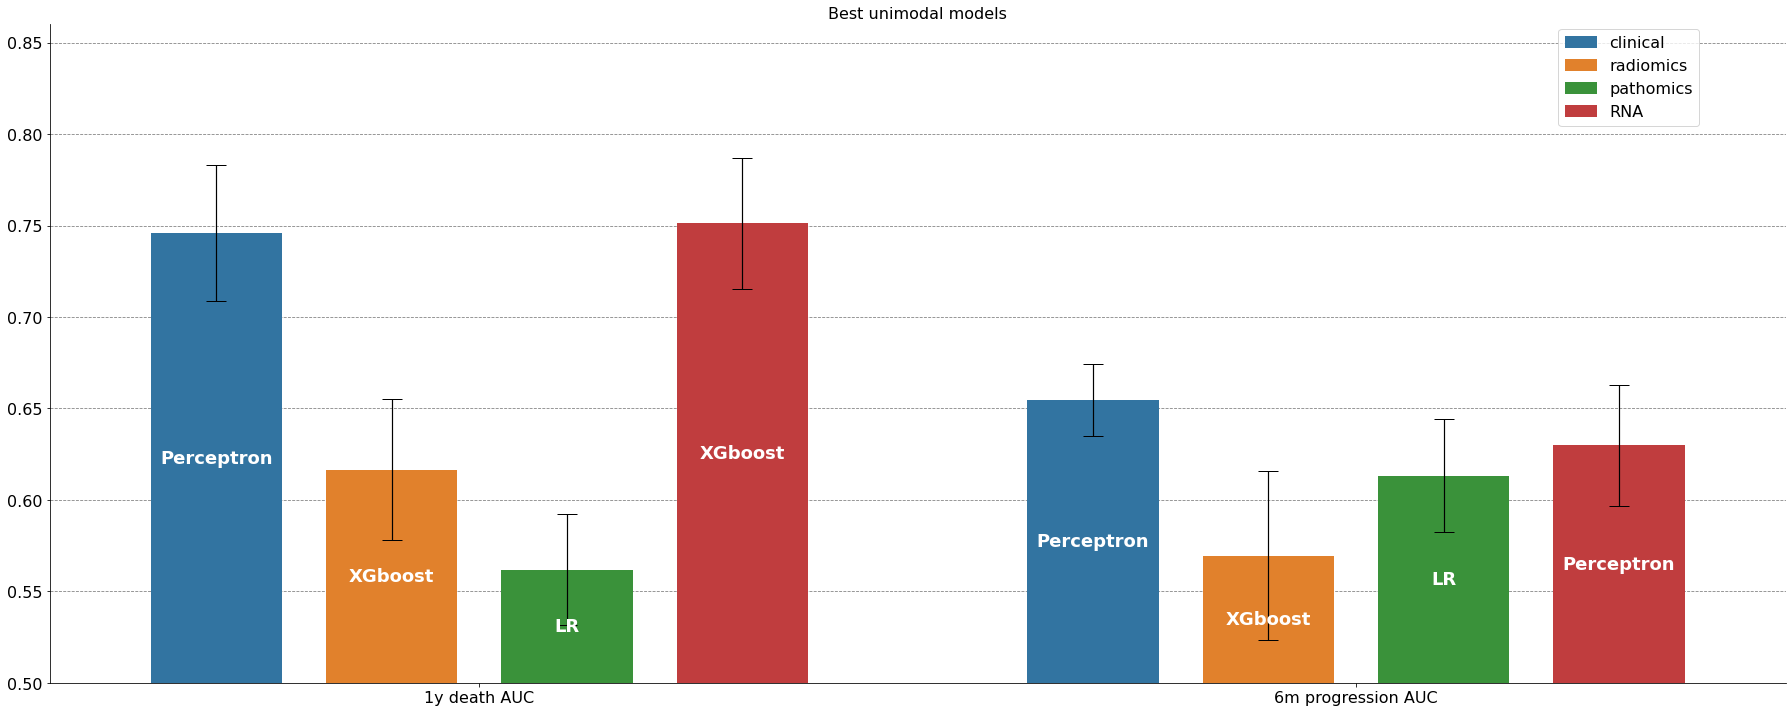

In [10]:
fig, ax = plt.subplots(figsize=(25, 10))

df_plot = results_unimodal.melt(id_vars = ["metric"])
sns.barplot(data=df_plot, x="metric", y="value", hue="variable", ax=ax, errorbar=None)
change_width(ax, 0.15)
errorbar(ax, results_unimodal)

models = ["XGboost", "LR", "XGboost", "XGboost", "LR", "LR", "Perceptron", "Perceptron", "Perceptron", "Perceptron"]
annotate_unimodal(ax, l1= [models[best_clinicals], models[best_radiomics], models[best_pathomics], models[best_RNA]],
                  l2=[models[best_clinicals_PFS], models[best_radiomics_PFS], models[best_pathomics_PFS], models[best_RNA_PFS]])

ax.legend(bbox_to_anchor=(0.955, 1.005), fontsize=16)
ax.set_ylim(0.5, 0.86)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
sns.despine()
ax.set_title("Best unimodal models", fontsize=16)
plt.tight_layout()

#### **Multimodal benchmark**

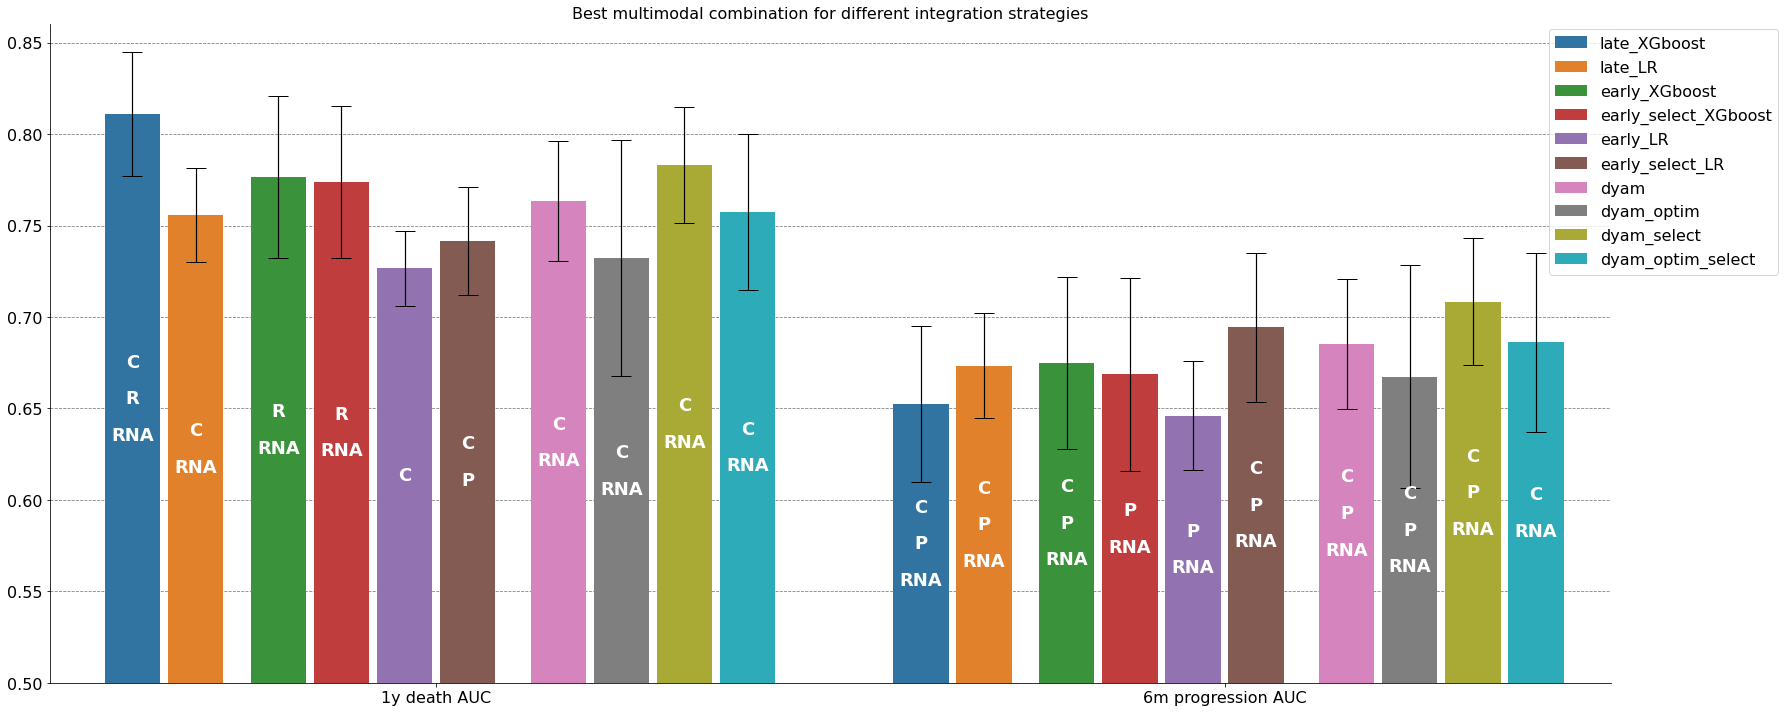

In [11]:
fig, ax = plt.subplots(figsize=(25, 10))

df_plot = results_multi.melt(id_vars = ["metric"])
sns.barplot(data=df_plot, x="metric", y="value", hue="variable", ax=ax, errorbar=None)
change_width(ax, 0.07, multi=True)
errorbar(ax, results_multi)

annotate_multimodal(ax, l1=list_best_OS, l2=list_best_PFS, dic = {"clinicals": "C", "radiomics": "R", "pathomics": "P", "RNA": "RNA"})

ax.legend(bbox_to_anchor=(0.955, 1.005), fontsize=16)
ax.set_ylim(0.5, 0.86)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
sns.despine()
ax.set_title("Best multimodal combination for different integration strategies", fontsize=16)
plt.tight_layout()

## 2. Benchmark for survival tasks

### 2.1 Define models to benchmark

In [12]:
#{model_name: (path for OS results, path for PFS results)}

models_dict = {'late_RF': ("survival\\RF_perm_100cv_OS\\", "survival\\RF_perm_100cv_PFS\\"),
               'late_Cox':  ("survival\\Cox_perm_100cv_OS\\", "survival\\Cox_perm_100cv_PFS\\"),
               'early_RF': ("survival_early\\RF_100CV_OS\\", "survival_early\\RF_100CV_PFS\\"),
               'early_select_RF': ("survival_early\\RF_select_bis_100cv_OS\\", "survival_early\\RF_select_bis_100cv_PFS\\"),
               'early_Cox':("survival_early\\Cox_100CV_OS\\", "survival_early\\Cox_100CV_PFS\\"),
               'early_select_Cox': ("survival_early\\Cox_select_bis_100CV_OS\\", "survival_early\\Cox_select_bis_100CV_PFS\\")}

### 2.2 Load data

In [13]:
df_omics = pd.read_csv("omics.csv", sep=";", index_col=0)
patient_omics = df_omics.index

df_clinicals = pd.read_csv("clinicals.csv", index_col = 0, sep=";")
bool_mask_OS = df_clinicals['OS'].isnull()
bool_mask_PFS = df_clinicals['PFS'].isnull()
df_clinicals_OS = df_clinicals[~bool_mask_OS]
patient_clinicals_OS = df_clinicals_OS.index
df_clinicals_PFS = df_clinicals[~bool_mask_PFS]
patient_clinicals_PFS = df_clinicals_PFS.index

df_radiomics = pd.read_csv("radiomics.csv", index_col=0, sep=";")
patient_radiomics = df_radiomics.index

patient_pathomics = pd.read_csv("pathomics.csv", index_col=0, sep=";").index

all_patients_OS = set(patient_radiomics) & set(patient_pathomics) & set(patient_clinicals_OS) & set(patient_omics)
all_patients_PFS = set(patient_radiomics) & set(patient_pathomics) & set(patient_clinicals_PFS) & set(patient_omics)

In [14]:
print("Patient OS: ", len(all_patients_OS))
print("Patient PFS: ", len(all_patients_PFS))

Patient OS:  79
Patient PFS:  80


### 2.3 Save best results for each model

In [15]:
def save_results_survival(df, patients, model, list_best, list_best_name, list_clin, list_rad, list_path, list_rna):
    # 1. Compute C_index
    data_train = Surv.from_arrays(event=df[df["repeat"] == 0]["label.event"].values,
                                  time=df[df["repeat"] == 0]["label.time"].values
                                 )
    results = compute_cindex(df.set_index("samples").loc[list(set(list(patients)) & set(df["samples"].unique()))],
                             names=list(df_OS.columns[2:-3].values),
                             data_train = data_train
                            )
    results = results[results["metric"] == "c_index"].drop(columns = "metric")
    
    # 2. Select model with the best average performance (over the repeats)
    best = results.mean().idxmax()
    list_best.append(results[best].rename(model))
    list_best_name.append(best)
    
    # 3. Save the performances of the unimodal models
    list_clin.append(results["clinicals"])
    list_rad.append(results["radiomics"])
    list_path.append(results["pathomics"])
    list_rna.append(results["RNA"])

In [16]:
list_OS, list_PFS = [], []
list_best_OS, list_best_PFS = [], []
list_clinicals_OS, list_radiomics_OS, list_pathomics_OS, list_RNA_OS = [], [], [], []
list_clinicals_PFS, list_radiomics_PFS, list_pathomics_PFS, list_RNA_PFS = [], [], [], []

for model, pathes in tqdm(models_dict.items(), total=len(models_dict)):
    df_OS = pd.read_csv(pathes[0] + "predictions.csv").rename(columns = {"Unnamed: 0": "samples"})
    df_PFS = pd.read_csv(pathes[1] + "predictions.csv").rename(columns = {"Unnamed: 0": "samples"})

    save_results_survival(df_OS, all_patients_OS, model, list_OS, list_best_OS, list_clinicals_OS, list_radiomics_OS, list_pathomics_OS, list_RNA_OS)
    save_results_survival(df_PFS, all_patients_PFS, model, list_PFS, list_best_PFS, list_clinicals_PFS, list_radiomics_PFS, list_pathomics_PFS, list_RNA_PFS)
    
# Concat best performances  
metric_OS = pd.concat(list_OS, axis=1)
metric_OS["metric"] = "OS C-index"
metric_PFS = pd.concat(list_PFS, axis=1)
metric_PFS["metric"] = "PFS C-index"

# Save best unimodal performances
best_clinicals = np.argmax([mod.mean() for mod in list_clinicals_OS])
best_radiomics = np.argmax([mod.mean() for mod in list_radiomics_OS])
best_pathomics = np.argmax([mod.mean() for mod in list_pathomics_OS])
best_RNA = np.argmax([mod.mean() for mod in list_RNA_OS])
unimodal_OS = pd.concat([list_clinicals_OS[best_clinicals], list_radiomics_OS[best_radiomics], list_pathomics_OS[best_pathomics], list_RNA_OS[best_RNA]], axis=1)
unimodal_OS["metric"] = "OS C-index"

best_clinicals_PFS = np.argmax([mod.mean() for mod in list_clinicals_PFS])
best_radiomics_PFS = np.argmax([mod.mean() for mod in list_radiomics_PFS])
best_pathomics_PFS = np.argmax([mod.mean() for mod in list_pathomics_PFS])
best_RNA_PFS = np.argmax([mod.mean() for mod in list_RNA_PFS])
unimodal_PFS = pd.concat([list_clinicals_PFS[best_clinicals_PFS], list_radiomics_PFS[best_radiomics_PFS], list_pathomics_PFS[best_pathomics_PFS], list_RNA_PFS[best_RNA_PFS]], axis=1)
unimodal_PFS["metric"] = "PFS C-index"

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:07<00:00, 11.32s/it]


In [17]:
results_multi = pd.concat([metric_OS, metric_PFS], axis=0)
results_multi.head()

,late_RF,late_Cox,early_RF,early_select_RF,early_Cox,early_select_Cox,metric
0,0.749478,0.624095,0.741186,0.691367,0.613522,0.707324,OS C-index
1,0.762107,0.668953,0.706343,0.745034,0.698746,0.694353,OS C-index
2,0.760881,0.645266,0.702678,0.715890,0.619757,0.705873,OS C-index
3,0.731493,0.664652,0.715622,0.748301,0.632621,0.720428,OS C-index
4,0.738403,0.632853,0.750647,0.729391,0.646983,0.694566,OS C-index


In [18]:
results_unimodal = pd.concat([unimodal_OS, unimodal_PFS], axis=0)
results_unimodal.head()

,clinicals,radiomics,pathomics,RNA,metric
0,0.659810,0.574972,0.607118,0.693620,OS C-index
1,0.695589,0.632664,0.597955,0.691800,OS C-index
2,0.690391,0.609958,0.589263,0.696218,OS C-index
3,0.668751,0.604428,0.627711,0.671152,OS C-index
4,0.671193,0.579824,0.603053,0.697055,OS C-index


### 2.4 Plot benchmark

In [19]:
def change_width(ax, new_value, multi=False) :
    """
    Change bar width
    """
    for i, patch in enumerate(ax.patches):
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
        # move groups of bars for multimodal benchmark
        if multi:
            if i in [0, 1, 2, 3]:
                patch.set_x(patch.get_x() + diff * .5 - 0.03)
      
def annotate_unimodal(ax, l1, l2):
    """
    Add text annotation on each bar for unimodal benchmark
    """
    for i, patch in enumerate(ax.patches[:len(l1) + len(l2)]):
        if i%2 == 0:
            model = l1[i//2]
        else:
            model = l2[i//2]
        height = patch.get_height()
        x_bar = patch.get_x() + 0.5*patch.get_width()
        ax.text(x_bar, height - (height - 0.5)/2 , model, weight='bold', va='center', ha='center', fontsize=18, color="white")

def annotate_multimodal(ax, l1, l2, dic):
    """
    Add text annotation on each bar for multimodal benchmark
    """
    for i, patch in enumerate(ax.patches[:len(l1)+len(l2)]):
        if i%2 == 0:
            modas = [dic[n] for n in l1[i//2].split('+')]
        else:
            modas = [dic[n] for n in l2[i//2].split('+')]
        n_modas = len(modas)
        height = patch.get_height()
        x_bar = patch.get_x() + 0.5*patch.get_width()
        for j, mod in enumerate(modas):
            ax.text(x_bar, height - (height - 0.5)/2 + (0.5*(n_modas-1) - j)*0.02, mod, weight='bold', va='center', ha='center', fontsize=18, color="white")
                        
def errorbar(ax, results):
    """
    Add error bar on each bar
    """
    for i, patch in enumerate(ax.patches[:2*(len(results.columns) - 1)]):
        columns = list(results.columns[:-1].values)
        x_bar = patch.get_x() + 0.5*patch.get_width()
        if i%2 == 0:
            m = "OS C-index"
        else:
            m = "PFS C-index"
            
        ax.errorbar(x=[patch.get_x() + 0.5*patch.get_width()],
                y=results[results["metric"] == m][columns[i//2]].mean(),
                yerr=results[results["metric"] == m][columns[i//2]].std(),
                fmt='none',
                ecolor='k',
                capsize=10,
                elinewidth=1.2)

#### **Unimodal benchmark**

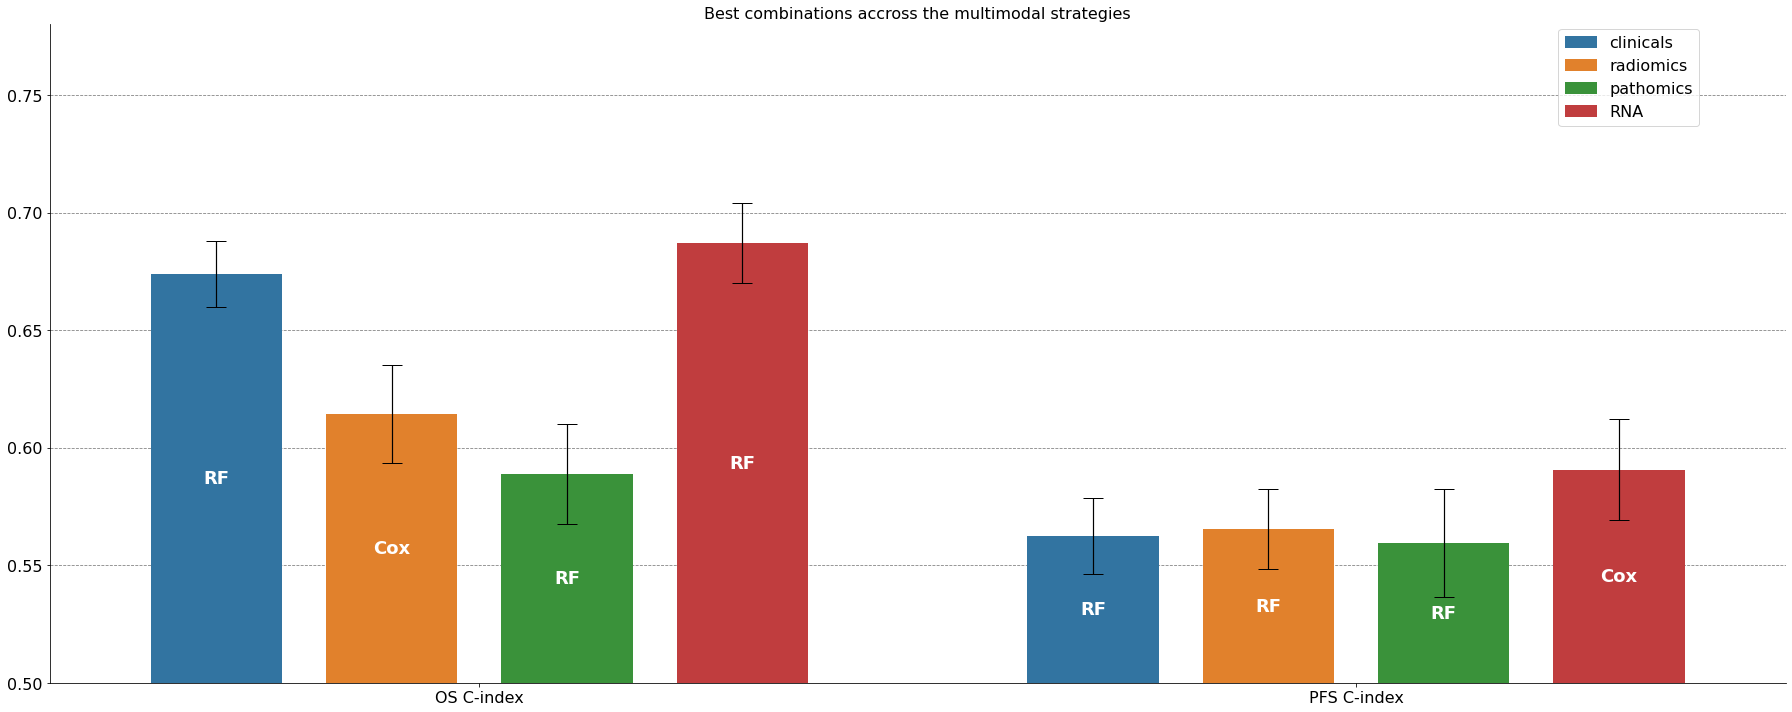

In [20]:
fig, ax = plt.subplots(figsize=(25, 10))

df_plot = results_unimodal.melt(id_vars = ["metric"])
sns.barplot(data=df_plot, x="metric", y="value", hue="variable", ax=ax, errorbar=None)
change_width(ax, 0.15)
errorbar(ax, results_unimodal)

models = ["RF", "Cox", "RF", "Cox", "Cox"] #["RF", "Cox", "RF", "RF", "Cox", "Cox"]
annotate_unimodal(ax, l1= [models[best_clinicals], models[best_radiomics], models[best_pathomics], models[best_RNA]],
         l2=[models[best_clinicals_PFS], models[best_radiomics_PFS], models[best_pathomics_PFS], models[best_RNA_PFS]])

ax.legend(bbox_to_anchor=(0.955, 1.005), fontsize=16)
ax.set_ylim(0.5, 0.78)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
sns.despine()
ax.set_title("Best combinations accross the multimodal strategies", fontsize=16)
plt.tight_layout()

#### **Multimodal benchmark**

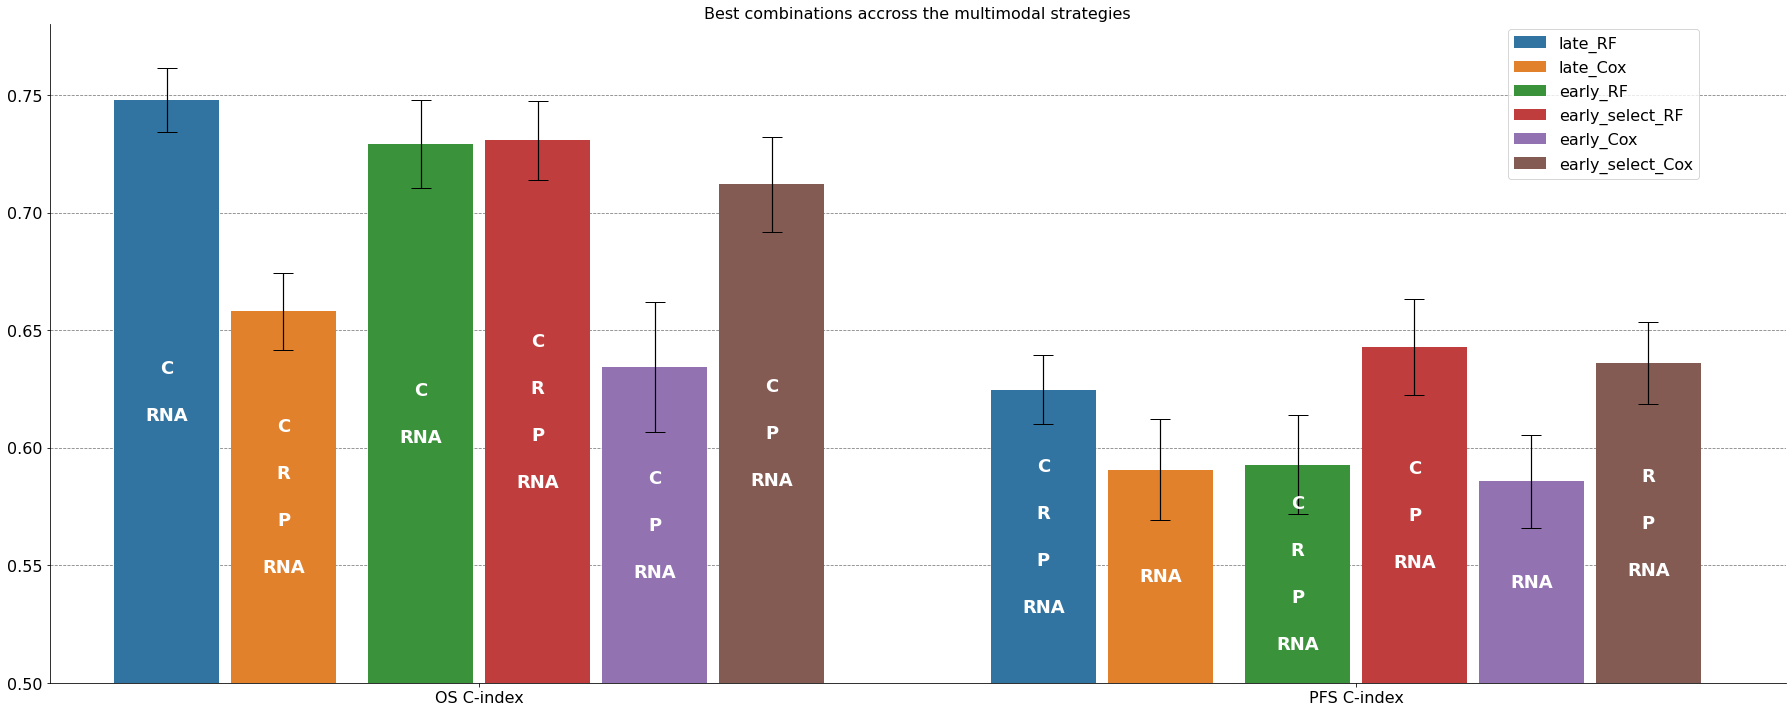

In [21]:
fig, ax = plt.subplots(figsize=(25, 10))

df_plot = results_multi.melt(id_vars = ["metric"])
sns.barplot(data=df_plot, x="metric", y="value", hue="variable", ax=ax, errorbar=None)
change_width(ax, 0.12, multi=True)
errorbar(ax, results_multi)

annotate_multimodal(ax, l1=list_best_OS, l2=list_best_PFS, dic = {"clinicals": "C", "radiomics": "R", "pathomics": "P", "RNA": "RNA"})

ax.legend(bbox_to_anchor=(0.955, 1.005), fontsize=16)
ax.set_ylim(0.5, 0.78)
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.set(xlabel=None, ylabel=None)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x', labelsize=16)
sns.despine()
ax.set_title("Best combinations accross the multimodal strategies", fontsize=16)
plt.tight_layout()